<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/05_ConvLSTM_Model_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/opportunistic-utm

Mounted at /content/drive
/content/drive/MyDrive/opportunistic-utm


# Check GPU

In [2]:
!nvidia-smi -L  

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-838b8e60-fb34-448f-9216-62836b569a3a)


In [3]:
!nvidia-smi

Thu Jul 21 12:47:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Define SARMSE Metric

In [4]:
# Spatially Averaged Root Mean Square
def SARMSE(original, predicted):
  layer_rmse = np.sqrt(np.sum(np.square(original-predicted)/100**2, axis=(0,1)))
  return np.sum(layer_rmse)/original.shape[-1] # divided by # of channels

# ConvLSTM Model

**Dependencies**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed, MaxPooling3D

**Custom Keras Loss Function**

In [6]:
from keras import backend as K

def custom_sarmse(y_true, y_pred):
  # print(f'True shape: {y_true.shape}')
  # print(f'Pred shape: {y_pred.shape}')
  a = K.square(y_true - y_pred + 1e-10)
  b = K.sum(a, [2,3], keepdims=True)
  c = K.sqrt(b)
  d = K.sum(c)/(100*20)
  return d

**Model**

In [46]:
inp = layers.Input(shape=(None, 100, 100, 20))
minp = layers.Input(shape=(None, 25))

def repeat_tabular(x_tab):
  h = x_tab[:, :, :, None, None]
  h = tf.tile(h, [1, 1, 4, 100, 1]) 
  return h
  
a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

y = tf.keras.layers.LSTM(64, return_sequences=True)(minp)
y = layers.Lambda(repeat_tabular)(minp)

x = tf.keras.layers.Concatenate()([a, b, c, y])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.1))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inputs = [inp, minp], outputs = x)
model.compile(
    loss=custom_sarmse, optimizer=keras.optimizers.Adam(learning_rate = 0.0005), run_eagerly=False,
)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 input_14 (InputLayer)          [(None, None, 25)]   0           []                               
                                                                                                  
 conv_lstm2d_24 (ConvLSTM2D)    (None, None, 100, 1  60032       ['input_13[0][0]']               
                                00, 32)                                                           
                                                                                            

**Train model**

In [8]:
import glob

# List of folders with data
files_list = []
for filename in glob.iglob(f'dataset/00_results/daily_masked/*.npy', recursive=False):
  files_list.append(filename)

files_list = np.sort(files_list).tolist()
print(f'Number of Files: {len(files_list)}')

Number of Files: 365


In [29]:
from tensorflow.keras.utils import Sequence
import numpy as np   
tf.config.run_functions_eagerly(True)

def shift_array(data, metadata, shift=1):
  xdata = data[:, 0 : data.shape[1] - shift, :, :]
  xmetadata = metadata[:, 0 : metadata.shape[1] - shift, :]

  ydata = data[:, shift : data.shape[1], :, :]
  ymetadata = metadata[:, shift : metadata.shape[1], :]

  return [xdata, xmetadata], [ydata, ymetadata]

class DataGenerator(Sequence):
  def __init__(self, files_list, batch_size):
    self.files_list = files_list
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.files_list) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_list = self.files_list[idx * self.batch_size:(idx + 1) * self.batch_size]
    data_array = np.empty((1,24,100,100,20))
    metadata_array = np.empty((1,24,25))

    for file in batch_list:
      data_file = np.load(file)
      data_array = np.concatenate((data_array, np.expand_dims(data_file, axis=0)), axis=0)

      metadata_file = np.load(file.replace('masked', 'metadata'))
      metadata_array = np.concatenate((metadata_array, np.expand_dims(metadata_file, axis=0)), axis=0)

    return shift_array(data_array[1:], metadata_array[1:])

train_gen = DataGenerator(files_list[0:250], 4)
val_gen = DataGenerator(files_list[250:300], 4)

In [47]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

# Fit the model to the training data.
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 75s 1s/step - loss: 20.0753 - val_loss: 15.7001 - lr: 5.0000e-04
Epoch 2/20
63/63 [==============================] - 74s 1s/step - loss: 8.8956 - val_loss: 4.3025 - lr: 5.0000e-04
Epoch 3/20
63/63 [==============================] - 76s 1s/step - loss: 2.5414 - val_loss: 2.3130 - lr: 5.0000e-04
Epoch 4/20
63/63 [==============================] - 74s 1s/step - loss: 1.8482 - val_loss: 2.1034 - lr: 5.0000e-04
Epoch 5/20
63/63 [==============================] - 76s 1s/step - loss: 1.7394 - val_loss: 2.0583 - lr: 5.0000e-04
Epoch 6/20
63/63 [==============================] - 73s 1s/step - loss: 1.7178 - val_loss: 2.0149 - lr: 5.0000e-04
Epoch 7/20
63/63 [==============================] - 73s 1s/step - loss: 1.7082 - val_loss: 1.9481 - lr: 5.0000e-04
Epoch 8/20
63/63 [==============================] - 70s 1s/step - loss: 1.6991 - val_loss: 1.8767 - lr: 5.0000e-04
Epoch 9/20
63/63 [==============================] - 71s 1s/step - loss: 1.6930 - val_loss

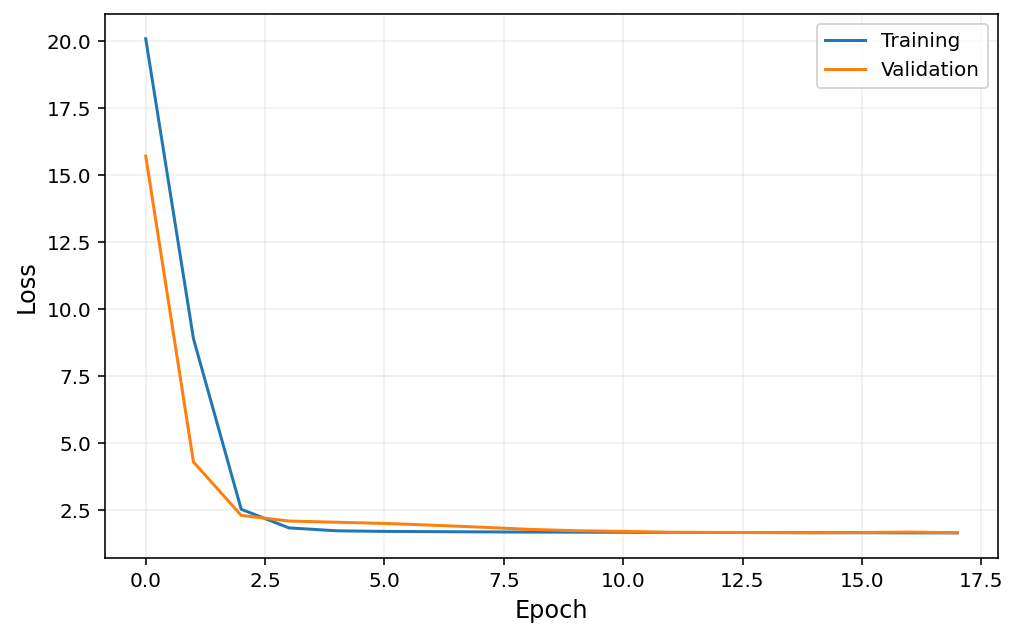

In [48]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('', fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.axis('on')
plt.grid('on', alpha=.2)
plt.show()

# Metrics and Visualization

**Compare truth vs prediction**

In [49]:
# Flattens multichannel array
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

In [33]:
# Load average flights array
flights_average = np.load(f'dataset/00_results/flights_average_365.npy')[0]
flights_average.shape

(100, 100, 20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


SARMSE ConvLSTM Prediction: 0.04260158074408601
SARMSE Average Prediction: 0.08031072045038407
Original Max: 0.6
Predicted Max: 0.5


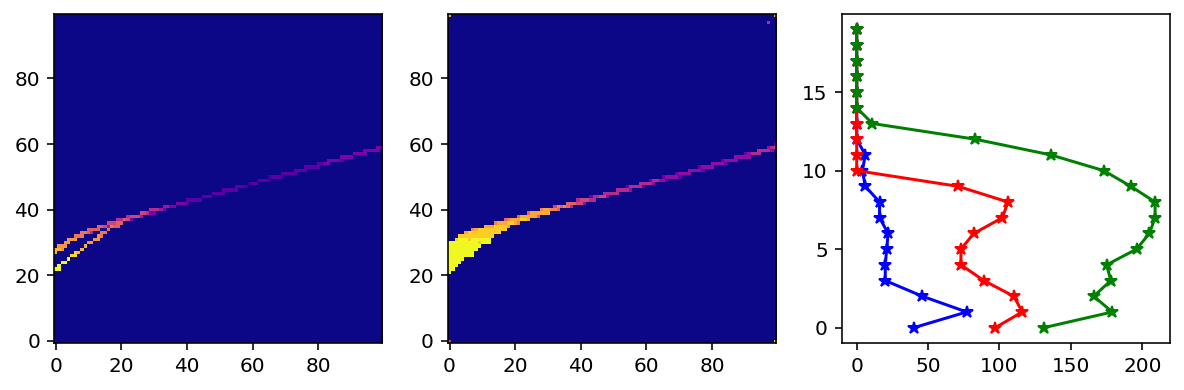

In [57]:
# Select a random example from the validation dataset.
hour = 0
file = 'dataset/00_results/daily_masked/20191204.npy'
example = np.load(file)
mexample = np.load(file.replace('masked', 'metadata'))

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
mframes = mexample[:10, ...]
original_frames = example[10:, ...]

new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mframes, axis=0)])
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
predicted_frame = np.where(predicted_frame > 0, 1, 0)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(131)
ax1.imshow(flatten_array(original_frames[hour]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

ax2 = fig.add_subplot(132)
ax2.imshow(flatten_array(predicted_frame[0]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

original_level_count = []
for i in range(0, 20):
  original_level_count.append(np.count_nonzero(original_frames[hour][:,:,i]))

predicted_level_count = []
for i in range(0, 20):
  predicted_level_count.append(np.count_nonzero(predicted_frame[0][:,:,i]))

average_level_count = []
for i in range(0, 20):
  average_level_count.append(np.count_nonzero(flights_average[:,:,i]))

ax3 = fig.add_subplot(133)
ax3.plot(original_level_count, np.linspace(0, 19, 20), 'b*-')
ax3.plot(predicted_level_count, np.linspace(0, 19, 20), 'r*-')
ax3.plot(average_level_count, np.linspace(0, 19, 20), 'g*-')

asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)

# print(f'SARMSE Null Prediction: {SARMSE(original_frames[0], np.zeros((100,100,20)))}')
print(f'SARMSE ConvLSTM Prediction: {SARMSE(original_frames[hour], predicted_frame[0])}')
print(f'SARMSE Average Prediction: {SARMSE(original_frames[hour], flights_average)}')
print(f'Original Max: {np.max(flatten_array(original_frames[hour]))}')
print(f'Predicted Max: {np.max(flatten_array(predicted_frame[0]))}')